In [ ]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from numpy import *

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [ ]:
root_url = "/content/drive/MyDrive/Paper/Safety_risk_2/DATA/"
sigement_size=180
channel = 7
file_names= [
  "R000N001","R100N001"
  ]
# file_names= [
#   "R000N001","R000N001_2","R000N050","R000N050_2","R000N100",
#   "R000N100_2","R000N200","R000N200_2","R000N300","R000N300_2",
#   "R050N050","R050N100","R050N200","R050N300","R050N001",
#   "R100N300","R100N200","R100N100","R100N050","R100N001",
#   "R200N300","R200N200","R200N100","R200N050","R200N001",
#   "R500N300","R500N200","R500N100","R500N050","R500N001"
#   ]


input = np.empty(shape=(0,channel,sigement_size))
label = np.empty(shape=(0))

for file_name in file_names:
  samples0 = np.loadtxt(open(root_url+file_name+"_S.csv","rb"),delimiter=",",skiprows=0)
  print(np.shape(samples0))

  input0 = np.reshape(samples0[:,0:sigement_size*channel],(len(samples0),channel,sigement_size))
  label0 = samples0[:,sigement_size*channel]

  input = np.vstack((input,input0)) 
  label = np.hstack((label,label0))

input = input.transpose(0,2,1)
print(np.shape(input))

(17922, 1261)
(18416, 1261)
(36338, 180, 7)


In [ ]:
reference_resistance = 100
y0 = np.log(reference_resistance/1e6)
y1 = np.log(reference_resistance/1e-1)
label = (label-y0)/(y1-y0)

In [ ]:
idx = np.random.permutation(len(label))
input_ramdom = input[idx]
label_ramdom = label[idx]

In [ ]:
test_size = 0.1  #[CHANGE]
cut_idx = int(round((1-test_size) * len(label)))
x_train, x_test = input_ramdom[:cut_idx], input_ramdom[cut_idx:]
y_train, y_test = label_ramdom[:cut_idx], label_ramdom[cut_idx:]

In [ ]:
norm_layer = keras.layers.Normalization(axis=-1)
adapt_data=input
norm_layer.adapt(adapt_data)

In [ ]:
input_shape=x_train.shape[1:]
model = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,

    layers.Conv1D(64, 2, activation='relu'),
    layers.Conv1D(64, 60, activation='relu'),

    layers.Conv1D(64, 3, activation='relu'),
    layers.Conv1D(64, 3, activation='relu'),
    layers.Conv1D(64, 3, activation='relu'),
    
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(1),
])

model.summary()
# keras.utils.plot_model(model,show_shapes=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 180, 7)           15        
 n)                                                              
                                                                 
 conv1d (Conv1D)             (None, 179, 64)           960       
                                                                 
 conv1d_1 (Conv1D)           (None, 120, 64)           245824    
                                                                 
 conv1d_2 (Conv1D)           (None, 118, 64)           12352     
                                                                 
 conv1d_3 (Conv1D)           (None, 116, 64)           12352     
                                                                 
 conv1d_4 (Conv1D)           (None, 114, 64)           12352     
                                                        

In [ ]:
epochs = 500
batch_size = 64

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae","mse"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
)

model.save(root_url)

model_name='RNN_test'
metric = "sparse_categorical_accuracy"
historyfile = open(root_url+model_name+".csv","w", encoding='utf-8', newline='')
writer = csv.writer(historyfile)
print(len(history.history[metric]))
for step in range(len(history.history[metric])):
  writer.writerow([step,history.history[metric][1],history.history["val_" + metric][1],history.history['loss'][1],history.history["val_loss"][1]])
historyfile.close()

Epoch 1/500
258/409 [=================>............] - ETA: 1:15 - loss: 2.2662 - mae: 0.7601 - mse: 2.2662

KeyboardInterrupt: ignored

In [ ]:
model_name='RNN_1C'
metric = "sparse_categorical_accuracy"
historyfile = open(root_url+model_name+".csv","w", encoding='utf-8', newline='')
writer = csv.writer(historyfile)
print(len(history.history[metric]))
for step in range(len(history.history[metric])):
  writer.writerow([step,history.history[metric][1],history.history["val_" + metric][1],history.history['loss'][1],history.history["val_loss"][1]])
historyfile.close()

500


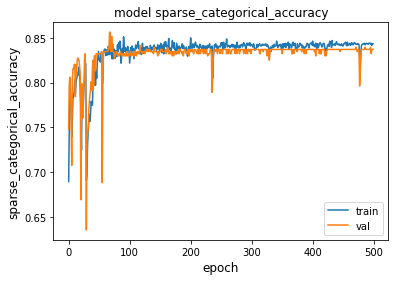

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.savefig(root_url+model_name+".png")
plt.show()
plt.close()

In [ ]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

8/8 [==============================] - 0s 9ms/step - loss: 0.2712 - sparse_categorical_accuracy: 0.8139
Test accuracy 0.8138527870178223
Test loss 0.27123159170150757
